In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark\\spark-2.4.3-bin-hadoop2.7'

In [2]:
import pyspark
from pyspark.sql import SQLContext
# Requirements for connection 
spark = pyspark.sql.SparkSession.builder \
   .master("local") \
   .config("spark.executor.memory", "2gb") \
   .getOrCreate()
# Spark context -  or connection 
sc = spark.sparkContext
# SQL context - or connection 
sqlContext = SQLContext(sc)

In [3]:
data = sc.textFile("Taxi.csv")

In [4]:
# Take the first n elements of the RDD
data.take(2)

['VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount',
 '']

In [5]:
# Explore the columns names
data.first()

'VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount'

In [7]:
# Get the first line of csv file
data.top(1)

['VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount']

In [8]:
# Get the variable type for spark context
type(data)

pyspark.rdd.RDD

In [9]:
# Schemas from SQL using a csv in pyspark
data2  = sqlContext.read.csv("taxi_dec.csv", header = True)

In [10]:
# Type of data2 when reading data using 
type(data2)

pyspark.sql.dataframe.DataFrame

In [11]:
# Display data types in the dataframe
data2.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)



In [ ]:
len(data2)

In [12]:
# Drops rows that contains na
data2.dropna()

DataFrame[VendorID: string, tpep_pickup_datetime: string, tpep_dropoff_datetime: string, passenger_count: string, trip_distance: string, RatecodeID: string, store_and_fwd_flag: string, PULocationID: string, DOLocationID: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string]

In [21]:
# Show stats for column passenger_count
data2.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|           8173231|
|   mean|1.5964102813195908|
| stddev| 1.233920232393633|
|    min|                 0|
|    max|                 9|
+-------+------------------+



In [ ]:
print('Column Names: ', data2.columns) # Column Names
print('Row Count: ', data2.count()) # Row Count
print('Column Count: ', len(data2.columns)) # Column Count

In [15]:
# describe three column's stats
data2.select('passenger_count', 'trip_distance', 'total_amount').describe().show()

+-------+------------------+------------------+------------------+
|summary|   passenger_count|     trip_distance|      total_amount|
+-------+------------------+------------------+------------------+
|  count|           8173231|           8173231|           8173231|
|   mean|1.5964102813195908|2.8926264215460553|16.524363505886303|
| stddev| 1.233920232393633| 3.764338945224816|120.42046343163905|
|    min|                 0|               .00|             -0.31|
|    max|                 9|             99.07|             99.98|
+-------+------------------+------------------+------------------+



In [17]:
from pyspark.sql.functions import isnan, when, count, col

# Perform tasks to check if any data within columns that contains NaN
# which should be zero because these data should have been dropped
data2.select([count(when(isnan(c), c)).alias(c) for c in data2.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         0|           0|                    0|           0|
+--------+--------------------+-----------------

In [18]:
data2.dropna().count()

8173231

In [24]:
# Filtering rides that has 1 to 4 passengers
data = data2.filter((data2.passenger_count <= 4) & (data2.passenger_count > 0))
# Filter rides that has more than $2.5
data = data.filter(data.total_amount >= 2.5)
# Filter rides with outlier effects, e.g. high fare or extra long distance
data = data.filter((data.total_amount < 200) & (data.trip_distance < 100))

In [25]:
# Filter accidental start of trips
data = data.filter(data.trip_distance > 0)

In [26]:
# Show stats for columns passenger_count and total_amount
data.select('passenger_count', 'total_amount').describe().show()

+-------+------------------+------------------+
|summary|   passenger_count|      total_amount|
+-------+------------------+------------------+
|  count|           5495209|           5495209|
|   mean|  1.34628091488422| 19.36391156930136|
| stddev|0.6915259106620711|14.465422201705064|
|    min|                 1|                10|
|    max|                 4|             99.98|
+-------+------------------+------------------+



In [27]:
# extract stats for columns
data.select('tpep_pickup_datetime', 'tpep_dropoff_datetime').describe().show()

+-------+--------------------+---------------------+
|summary|tpep_pickup_datetime|tpep_dropoff_datetime|
+-------+--------------------+---------------------+
|  count|             5495209|              5495209|
|   mean|                null|                 null|
| stddev|                null|                 null|
|    min| 2003-12-23 05:01:51|  2003-12-23 05:09:00|
|    max| 2020-12-10 20:34:26|  2020-12-10 20:54:46|
+-------+--------------------+---------------------+



In [28]:
# Get the number of pickups from different locations
pickups = data.select(col('PULocationID').alias('LocationID'))\
                        .groupBy('LocationID')\
                        .count()\
                        .sort('LocationID')\
                        .select(col('count').alias('pickups'), col('LocationID'))

In [29]:
# Get the number of dropoffs from different locations
dropoffs = data.select(col('DOLocationID')\
                        .alias('LocationID'))\
                        .groupBy('LocationID')\
                        .count()\
                        .sort('LocationID')\
                        .select(col('count').alias('dropoffs'), col('LocationID'))

In [30]:
# Join the count for pickups and dropoffs based on Location ID
picks_drops = pickups.join(dropoffs, on= ['LocationID'])

In [31]:
# Show joined table
picks_drops.show()

+----------+-------+--------+
|LocationID|pickups|dropoffs|
+----------+-------+--------+
|       125|  30437|   26820|
|       124|    210|     858|
|        51|    544|    1388|
|         7|   8222|   28315|
|       169|    277|    1530|
|       205|    575|    1398|
|        15|     88|     651|
|       232|   9827|   28553|
|       234| 156298|  125827|
|        54|    202|    1722|
|       155|    470|    1204|
|       132| 165174|   54698|
|       154|     27|      70|
|       200|    227|    2382|
|       101|    159|     544|
|        11|    102|     621|
|       138| 188565|   78204|
|        29|    140|     750|
|        69|    662|    3426|
|       112|   2182|   15268|
+----------+-------+--------+
only showing top 20 rows



In [33]:
# Convert from SQL context dataframe to Pandas dataframe
picks_drops = picks_drops.toPandas()

In [34]:
# Print head of data frame
picks_drops.head()

,LocationID,pickups,dropoffs
0,125,30437,26820
1,124,210,858
2,51,544,1388
3,7,8222,28315
4,169,277,1530


In [35]:
# Consolidate dropoff and picket count
picks_drops['total'] = picks_drops['pickups'] + picks_drops['dropoffs']

In [36]:
# Import libraries
import pandas as pd
import numpy as np

In [37]:
# Import GeoPandas lib
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [38]:
# Read map data
NYC_map = geopandas.read_file('taxi_zones/taxi_zones.shp')
NYC_map.crs

{'init': 'epsg:2263'}

In [39]:
# Examine data sample
NYC_map.tail()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.781960189 270986.1393638253,..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966050446 216463.0052037984,..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.2043112218 196138.486258477, ..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,(POLYGON ((999804.7945504487 224498.5270484537...
262,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.3227153122 220912.3861623257,..."


In [40]:
# Force location ID to become integer number instead of string
picks_drops['LocationID'] = picks_drops['LocationID'].astype(int)
picks_drops.dtypes

LocationID    int32
pickups       int64
dropoffs      int64
total         int64
dtype: object

In [41]:
# Joining two tables based on location 
NYC = NYC_map.merge(picks_drops, on = 'LocationID')

In [42]:
# Examine final data frame sample
NYC.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,pickups,dropoffs,total
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",89,13495,13584
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",7,10,17
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",138,526,664
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",11519,26934,38453
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",12,77,89


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>


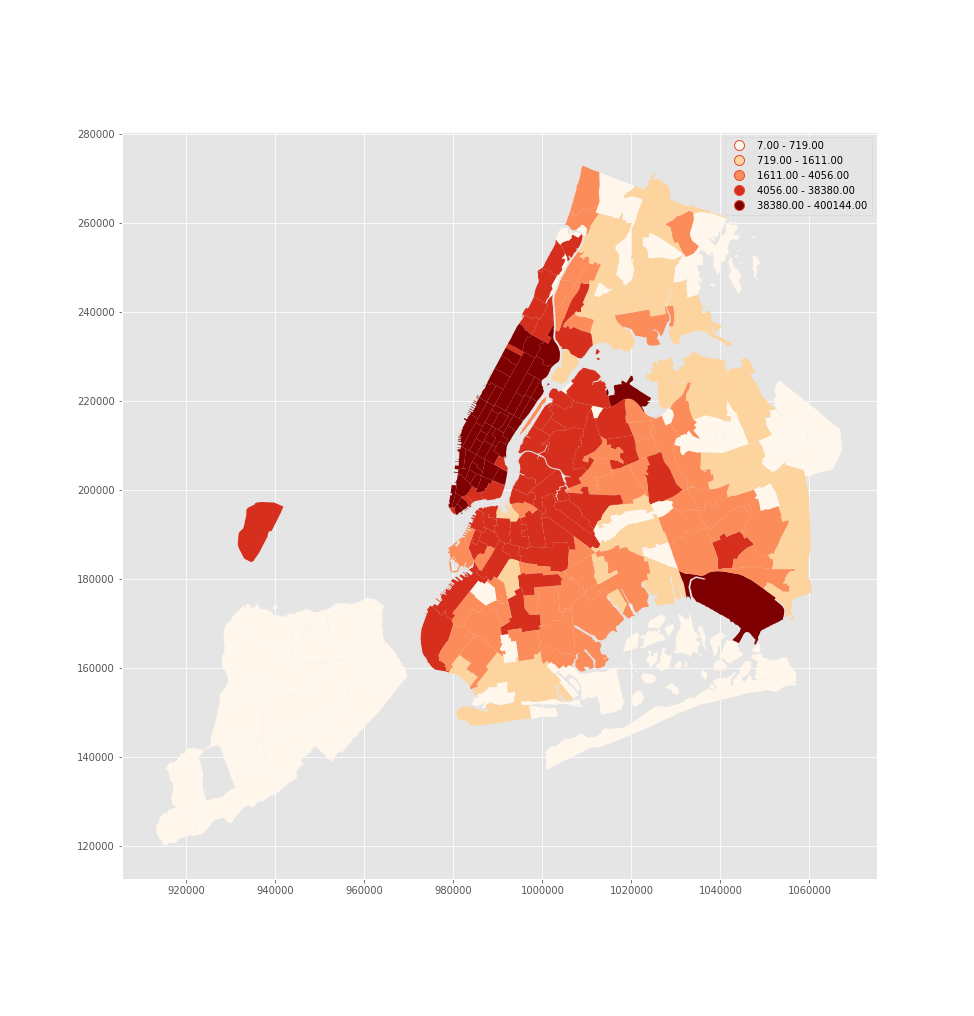

In [51]:
# Plot heatmap based on the location and the number of pickups and dropoffs happend locally
%matplotlib notebook
fig, ax = plt.subplots(1, 1)
NYC.plot(column = 'total', cmap='OrRd', scheme='quantiles', legend=True)

In [46]:
# Sort zones and select area that we should target
top_pickups = NYC[['pickups', 'zone', 'borough']].sort_values('pickups', ascending = False)

In [47]:
# Show top boroughs that we should target
top_pickups.head(10)

,pickups,zone,borough
229,205853,Upper East Side South,Manhattan
228,199764,Upper East Side North,Manhattan
180,198725,Penn Station/Madison Sq West,Manhattan
155,192913,Midtown Center,Manhattan
132,188565,LaGuardia Airport,Queens
156,185652,Midtown East,Manhattan
136,178297,Lincoln Square East,Manhattan
222,171655,Times Sq/Theatre District,Manhattan
46,170440,Clinton East,Manhattan
126,165174,JFK Airport,Queens


In [52]:
# Release resources
sc.close()

AttributeError: 'SparkContext' object has no attribute 'close'

In [108]:
# Get the number of pickups from different locations
pickups = data.select(data.total_amount.cast('float').alias('amount'), col('PULocationID').alias('LocationID')) \
                        .groupBy('LocationID')\
                        .mean()\
                        .sort('LocationID')\
                        .select(col('avg(amount)').alias('amount'), col('LocationID'))
pickups

DataFrame[amount: double, LocationID: string]

In [ ]:
pickups